In [1]:
import keras

Using TensorFlow backend.


## 原始資料來源的 SQL，這是抽樣過的資料，當中也有一筆資料是修改過的，因為當天 Server 似乎出了一些問題，導至流量大幅下降



In [2]:
sql = """
SELECT 
date,count(distinct cookie_pta) as uv
from
TABLE_DATE_RANGE(pixinsight.article_visitor_log_1_100_, TIMESTAMP('2017-01-01'), CURRENT_TIMESTAMP())
where venue = 'pixnet'
group by date
order by date
"""

In [3]:
from os import environ
# load and plot dataset
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import matplotlib.dates as mdates

%matplotlib notebook

# %matplotlib inline  

# load dataset
def parser(x):
    return datetime.strptime(x, '%Y%m%d')

series = pd.read_gbq(sql,project_id=environ['PROJECT_ID'], verbose=False, private_key=environ['GOOGLE_KEY'])#,header=0, parse_dates=[0], index_col='date', squeeze=True, date_parser=parser)
series['date'] = pd.to_datetime(series['date'],format='%Y%m%d')
series.index = series['date']
del series['date']

# summarize first few rows
print(series.head())


               uv
date             
2017-01-01  38633
2017-01-02  39509
2017-01-03  42734
2017-01-04  43611
2017-01-05  40036


## 進行 scale to 0-1 ，方便作為 input 及 output (因為 sigmoid 介於 0~1 之間)

In [4]:
from sklearn.preprocessing import scale,MinMaxScaler
scaler = MinMaxScaler()

In [5]:
x = series.values

In [6]:
x = x.reshape([x.shape[0],1])

In [7]:
scaler.fit(x)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
x_scaled = scaler.transform(x)

<IPython.core.display.Javascript object>


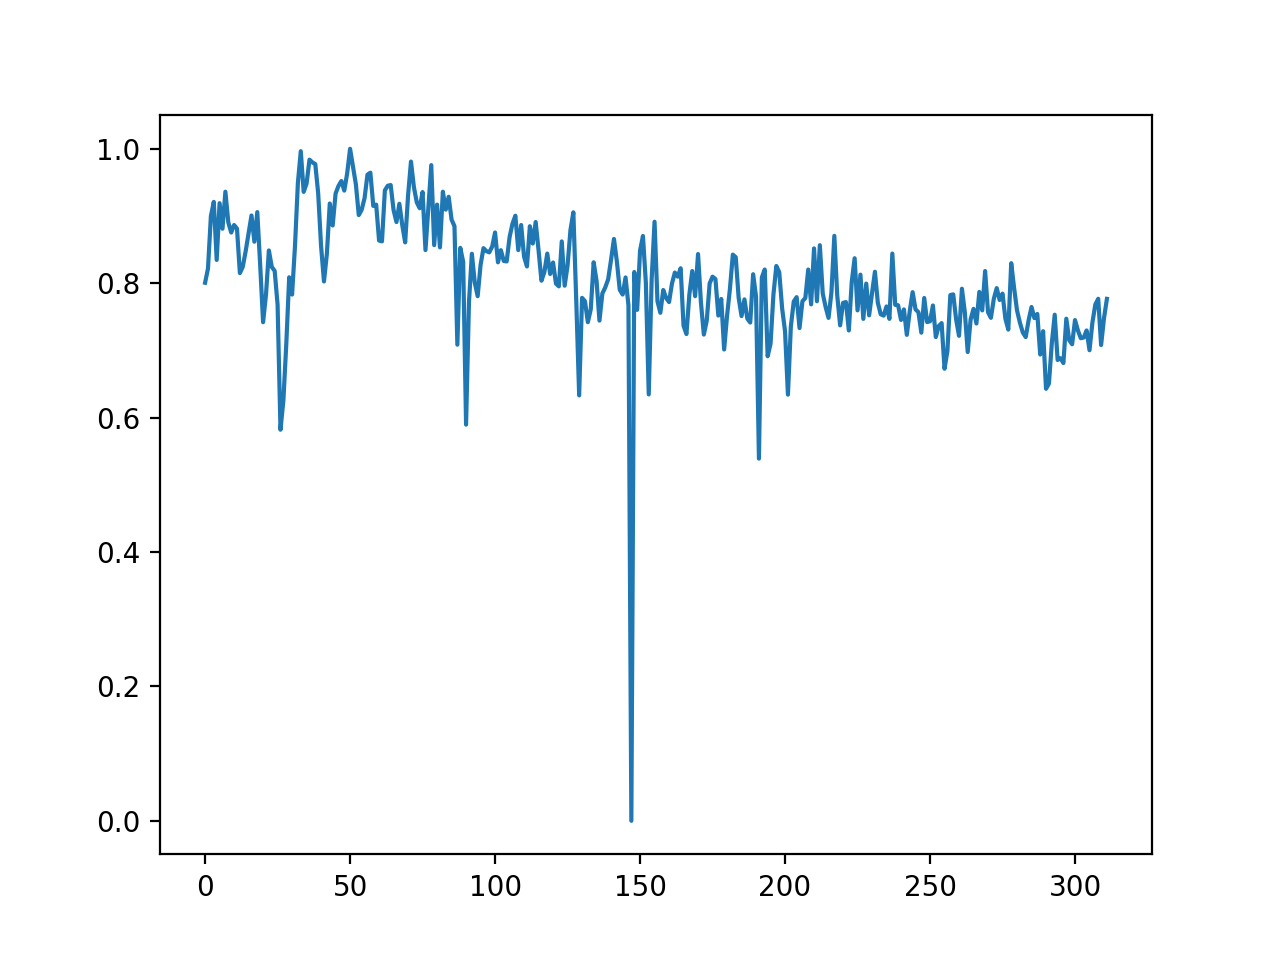

In [9]:
pyplot.figure()
pyplot.plot(x_scaled)
pyplot.show()

## 產生 x,y pair 
* 舉列來說假設將 Step Size 設為 4 天，故一筆 Training Data ，為連續 4 天的流量。再來利用這４天的資料來預測第 5 天的流量
* 綠色的部是 Training Data(前4天的資料)，藍色的部份是需要被預測的部份。示意如下圖
* <img align="left" width="50%" src="./imgs/sequence_uv.png" />

In [10]:
#往回看 30 天前的每一筆資料
step_size = 15

In [11]:
print("原始資料長度:{}".format(x_scaled.shape))

原始資料長度:(312, 1)


In [12]:
def window_stack(a, stepsize=1, width=3):
    return np.hstack( a[i:1+i-width or None:stepsize] for i in range(0,width) )

import numpy as np
train_x = window_stack(x_scaled, stepsize=1, width=step_size)

In [13]:
# 最後一筆資料要放棄，因為沒有未來的答案作驗證

train_x = train_x[:-1]
train_x.shape

(297, 15)

In [14]:
# 請注意千萬不將每一筆(Row) 當中的最後一天資料作為 Training Data 中的 Input Data
train_y = np.array([i for i in x_scaled[step_size:]]) 

## 確認產出來的 Training Data 沒有包含到 Testing Data

In [15]:
train_y.shape

(297, 1)

In [16]:
train_x[0]

array([ 0.80070082,  0.82187047,  0.89980667,  0.92100048,  0.83460609,
        0.91906718,  0.88105365,  0.93615273,  0.89059932,  0.87539874,
        0.88653939,  0.88124698,  0.81500725,  0.82450459,  0.84775254])

In [17]:
train_x[1]

array([ 0.82187047,  0.89980667,  0.92100048,  0.83460609,  0.91906718,
        0.88105365,  0.93615273,  0.89059932,  0.87539874,  0.88653939,
        0.88124698,  0.81500725,  0.82450459,  0.84775254,  0.87426293])

In [18]:
train_y[0]

array([ 0.87426293])

## Design Graph

In [19]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(train_x, (train_x.shape[0], step_size, 1))

In [20]:
from keras import Sequential
from keras.layers import LSTM,Dense
# create and fit the LSTM network
model = Sequential()
# input_shape(step_size,feature_dim)
model.add(LSTM(4, input_shape=(step_size,1), unroll=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


## 最後30 筆資料不要看

In [21]:
validation_size = 60

In [52]:
val_loss = []
loss = []
for _ in range(400):
    history = model.fit(trainX[:-1*validation_size],
              train_y[:-1*validation_size],
              epochs=1,shuffle=False, 
              validation_data=(trainX[-1*validation_size:],
              train_y[-1*validation_size:]))
    
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    model.reset_states()

Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 669us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 644us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 668us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 663us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 647us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==========================

237/237 [==============================] - 0s 645us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 648us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 669us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 668us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 654us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 633us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 653us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 648us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 658us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 644us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 652us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 670us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 637us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 657us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 643us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 638us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 638us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 660us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 643us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 668us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 640us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 646us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 641us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 645us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 646us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 641us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 655us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 652us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 642us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 633us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 670us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 644us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 654us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 646us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 659us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 670us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 639us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 639us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 645us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 644us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 638us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 670us/step - loss: 0.0061 - acc: 0.0042 - va

237/237 [==============================] - 0s 646us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 644us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 648us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 643us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 641us/step - loss: 0.0061 - acc: 0.0042 - val_loss: 0.0012 - val_acc: 0.0000e+00
Train on 237 samples, validate on 60 samples
Epoch 1/1
237/237 [==============================] - 0s 641us/step - loss: 0.0061 - acc: 0.0042 - va

## 看一下 Error Rate 曲線

<IPython.core.display.Javascript object>


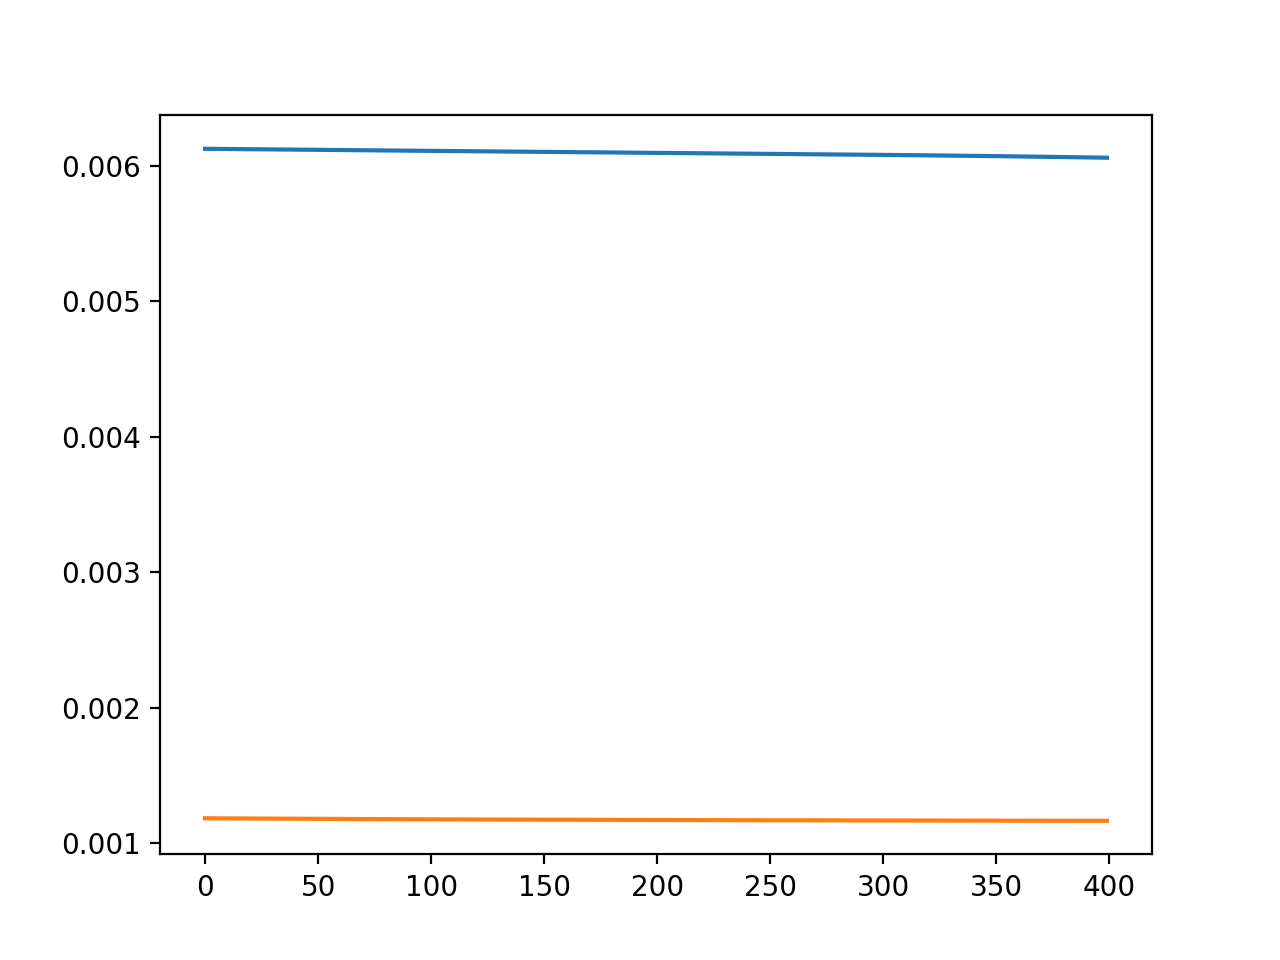

In [53]:
pyplot.figure()
pyplot.plot(loss)
pyplot.plot(val_loss)
pyplot.show()

# 看一下曲線擬合效果

In [54]:
predict_y = model.predict(trainX)

In [55]:
train_y.shape

(297, 1)

<IPython.core.display.Javascript object>


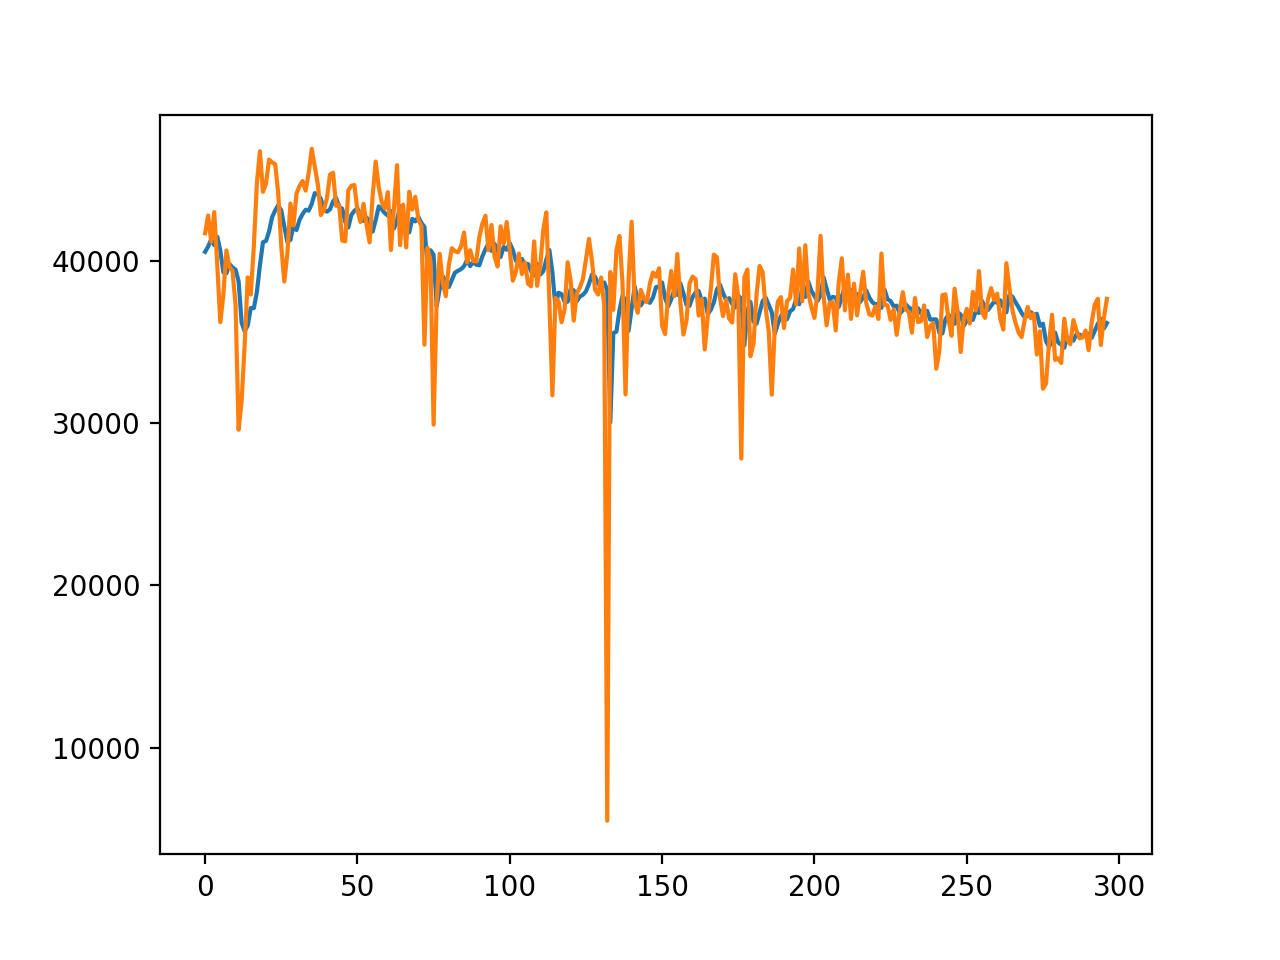

In [56]:
pyplot.figure()
pyplot.plot(scaler.inverse_transform(predict_y))
pyplot.plot(scaler.inverse_transform(train_y))

pyplot.show()

## 來預測最後 60 天資料預出來的結果

In [57]:
predict_y = model.predict(trainX[-1*validation_size:])

In [58]:
predict_y = scaler.inverse_transform(predict_y)

In [59]:
predict_y.shape

(60, 1)

<IPython.core.display.Javascript object>


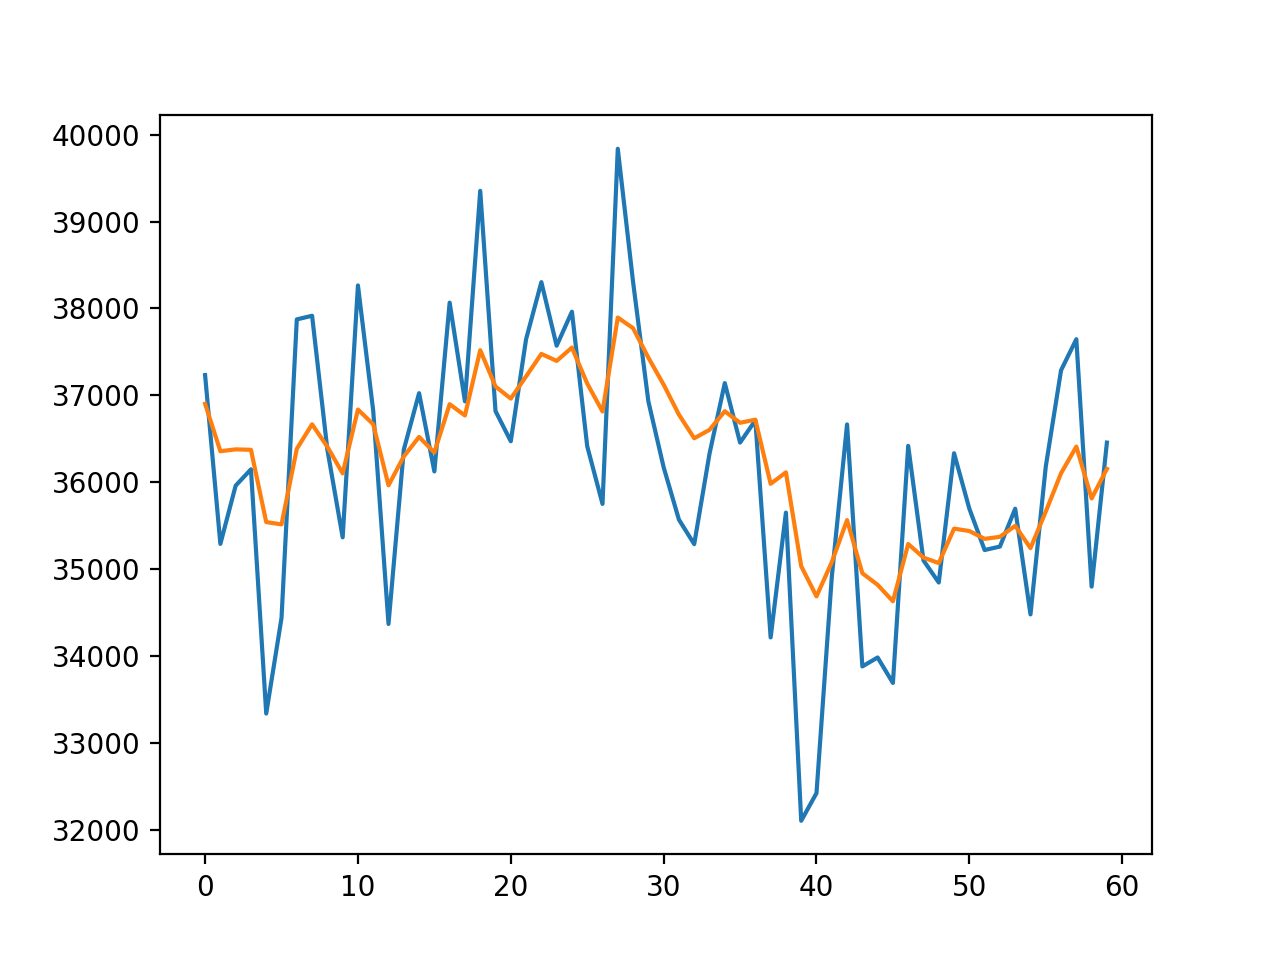

In [60]:
pyplot.figure()
pyplot.plot(x[-1*(validation_size+1):-1])
pyplot.plot(predict_y)


pyplot.show()

## 心得觀察
* LSTM 可以學習到 Period Pattern 是沒有問題的，但是似乎對於大幅的震盪以目前的 Model 來說無法完全的 Catch 到，但是還是有學到漲幅的趨勢預測
* 至於 LSTM 要如何調整震盪的幅度有兩個想法可以實驗看看
 * 直接 Modified Training，將震盪幅度加大
 * 修改 Loss Function ，把平方改為 2.x 次方不知道是否有效果